In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")

submissionFile = pd.read_csv("sample_submission.csv")

In [87]:
#Combine test and train into one file
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train, test], ignore_index=True)
print(train.shape, test.shape, data.shape)

(95662, 17) (45019, 16) (140681, 17)


C:\Users\mo.yosiwealth\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [88]:
#Drop the columns
data.drop(['CountryCode','CurrencyCode','BatchId','AccountId',
           'SubscriptionId','CustomerId','TransactionId','TransactionStartTime'],axis=1,inplace=True)

In [89]:
from feature_engine import categorical_encoders as ce

ohe_enc = ce.OneHotCategoricalEncoder(
    top_categories=None,
    variables=["ProviderId", "ProductCategory", "ProductId",  "ChannelId"],#"Credit_Debit"]],
    drop_last=False)

ohe_enc.fit(data)
data = ohe_enc.transform(data)
ohe_enc.encoder_dict_

{'ProviderId': array(['ProviderId_6', 'ProviderId_4', 'ProviderId_1', 'ProviderId_5',
        'ProviderId_3', 'ProviderId_2'], dtype=object),
 'ProductCategory': array(['airtime', 'financial_services', 'utility_bill', 'data_bundles',
        'tv', 'transport', 'ticket', 'movies', 'other', 'retail'],
       dtype=object),
 'ProductId': array(['ProductId_10', 'ProductId_6', 'ProductId_1', 'ProductId_21',
        'ProductId_3', 'ProductId_15', 'ProductId_11', 'ProductId_19',
        'ProductId_4', 'ProductId_5', 'ProductId_20', 'ProductId_9',
        'ProductId_24', 'ProductId_14', 'ProductId_2', 'ProductId_13',
        'ProductId_22', 'ProductId_8', 'ProductId_7', 'ProductId_27',
        'ProductId_12', 'ProductId_16', 'ProductId_23', 'ProductId_26',
        'ProductId_25', 'ProductId_18', 'ProductId_17'], dtype=object),
 'ChannelId': array(['ChannelId_3', 'ChannelId_2', 'ChannelId_1', 'ChannelId_5',
        'ChannelId_4'], dtype=object)}

In [91]:
data["IDK"] = (data['Value'] // data["PricingStrategy"]).astype('float')

In [92]:
data.drop(['Value'],axis=1,inplace=True)#'PricingStrategy',

In [93]:
data.head()

,Amount,FraudResult,PricingStrategy,source,ProviderId_ProviderId_6,ProviderId_ProviderId_4,ProviderId_ProviderId_1,ProviderId_ProviderId_5,ProviderId_ProviderId_3,ProviderId_ProviderId_2,...,ProductId_ProductId_26,ProductId_ProductId_25,ProductId_ProductId_18,ProductId_ProductId_17,ChannelId_ChannelId_3,ChannelId_ChannelId_2,ChannelId_ChannelId_1,ChannelId_ChannelId_5,ChannelId_ChannelId_4,IDK
0,1000.0,0.0,2,train,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,500.0
1,-20.0,0.0,2,train,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,10.0
2,500.0,0.0,2,train,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,250.0
3,20000.0,0.0,2,train,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,10900.0
4,-644.0,0.0,2,train,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,322.0


In [37]:
data.drop(['ProductId'],axis=1,inplace=True)

In [95]:
#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

In [96]:
#Drop unnecessary columns:
labels = train.FraudResult

test.drop(['FraudResult','source'],axis=1,inplace=True)
train.drop(['FraudResult','source'],axis=1,inplace=True)


C:\Users\mo.yosiwealth\Anaconda\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [99]:
data.FraudResult.value_counts()

0.0    95469
1.0      193
Name: FraudResult, dtype: int64

In [100]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import plot_tree
from xgboost import plot_importance
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.feature_selection import SelectFromModel
from numpy import sort

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.4, random_state=0)  
X_train.shape, X_test.shape

((57397, 51), (38265, 51))

In [103]:
from imblearn.over_sampling import SMOTE

smt = SMOTE(sampling_strategy='minority')#, k_neighbors=3, n_jobs=1)
X_train, y_train = smt.fit(X_train, y_train)

#np.bincount(y_train_smote)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [71]:
a=pd.DataFrame(y_train)

In [72]:
a[0].value_counts()

1.0    57276
0.0    57276
Name: 0, dtype: int64

In [73]:
X_train = pd.DataFrame(X_train, columns=train.columns)

In [104]:
X_train.head()

,Amount,PricingStrategy,ProviderId_ProviderId_6,ProviderId_ProviderId_4,ProviderId_ProviderId_1,ProviderId_ProviderId_5,ProviderId_ProviderId_3,ProviderId_ProviderId_2,ProductCategory_airtime,ProductCategory_financial_services,...,ProductId_ProductId_26,ProductId_ProductId_25,ProductId_ProductId_18,ProductId_ProductId_17,ChannelId_ChannelId_3,ChannelId_ChannelId_2,ChannelId_ChannelId_1,ChannelId_ChannelId_5,ChannelId_ChannelId_4,IDK
28189,1000.0,4,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,250.0
32028,-50.0,2,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,25.0
81030,10000.0,2,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,5000.0
86655,7000.0,4,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1750.0
2146,2000.0,4,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,500.0


In [105]:
# xg_cl = xgb.XGBClassifier(objective='binary:logistic',learning_rate=0.01,subsample=0.55,n_estimators=200, seed=123)

xg_cl = xgb.XGBClassifier(objective='binary:logistic',learning_rate=0.1)#,scale_pos_weight=500)
#eval_set = [(X_train, y_train), (X_test, y_test)]
xg_cl.fit(X_train, y_train, verbose=True)#sample_weight=w_array,eval_metric=["error","logloss","auc"], eval_set=eval_set)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [106]:
preds = xg_cl.predict(X_test)

In [107]:
print('Accuracy: {0:.5f}'.format(accuracy_score(y_test, preds)))
print('Precision: {0:.5f}'.format(precision_score(y_test, preds)))
print('Recall: {0:.5f}'.format(recall_score(y_test, preds)))
print('F1: {0:.5f}'.format(f1_score(y_test, preds)))

Accuracy: 0.99935
Precision: 0.87302
Recall: 0.76389
F1: 0.81481


<Figure size 432x288 with 0 Axes>

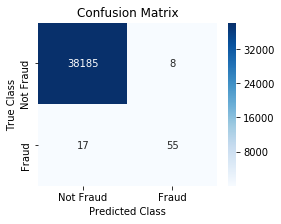

In [108]:
#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(y_test, preds)
labels = ['Not Fraud', 'Fraud']
plt.figure(figsize=(4,3))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [109]:
prediction = xg_cl.predict(test)
submission = pd.DataFrame({
    "TransactionId": submissionFile["TransactionId"],
    "FraudResult": prediction
})

submission.to_csv('submission2.csv', index=False)

In [110]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

In [111]:
clf = clf.fit(X_train, y_train)                                                             
prediction = clf.predict(X_test)                                         
print(prediction) 

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
print('Accuracy: {0:.5f}'.format(accuracy_score(y_test, preds)))
print('Precision: {0:.5f}'.format(precision_score(y_test, preds)))
print('Recall: {0:.5f}'.format(recall_score(y_test, preds)))
print('F1: {0:.5f}'.format(f1_score(y_test, preds)))

print(classification_report(y_test, preds))

In [ ]:
#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(y_test, preds)
labels = ['Not Fraud', 'Fraud']
plt.figure(figsize=(4,3))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()